# Data preprocessing 

In [1]:
import pandas
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
import torch
from torch.utils.data import DataLoader

In [2]:
Data = pandas.read_csv('Cleaned_Data.csv')
tokenizer = get_tokenizer('basic_english')
counter = Counter()
for line , label in zip(Data['file content'] ,Data['class number']) :
    counter.update(tokenizer(line))
vocab = Vocab(counter, min_freq=1)

In [3]:
iter_data = Data.to_records(index=False)
iter_data = list(iter_data)

In [4]:
text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_text , _label) in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

dataloader = DataLoader(iter_data, batch_size=8, shuffle=False, collate_fn=collate_batch)

# Model buidling

In [6]:
from torch import nn
from torch.utils.data.dataset import random_split

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
        self.dropout = nn.Dropout(p=0.50)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        embedded = self.dropout(embedded)
        return self.fc(embedded)

In [7]:
num_class = len(set([label for (text, label) in iter_data]))
vocab_size = len(vocab)
emsize = 128
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [27]:
print(model)


TextClassificationModel(
  (embedding): EmbeddingBag(64964, 128, mode=mean)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=20, bias=True)
)


In [8]:
import time
train_acc_list =[]
train_loss_list =[]

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 50
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predited_label = model(text, offsets)
        loss = criterion(predited_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()
    train_acc_list.append(total_acc/total_count)
    train_loss_list.append(loss)

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predited_label = model(text, offsets)
            loss = criterion(predited_label, label)
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count , loss

In [9]:
# Hyperparameters
EPOCHS = 15 # epoch
LR = 0.85 # learning rate
BATCH_SIZE = 32 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

num_train = int(len(iter_data) * 0.80)

train_dataset, test_dataset = random_split(iter_data, [num_train, len(iter_data) - num_train])

num_train = int(len(train_dataset) * 0.95)

split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

val_acc_list = []
val_loss_list = []

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val , val_loss = evaluate(valid_dataloader)
    val_acc_list.append(accu_val)
    val_loss_list.append(val_loss)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f}'.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val ))
    print('-' * 59)

| epoch   1 |    50/  445 batches | accuracy    0.237
| epoch   1 |   100/  445 batches | accuracy    0.352
| epoch   1 |   150/  445 batches | accuracy    0.404
| epoch   1 |   200/  445 batches | accuracy    0.476
| epoch   1 |   250/  445 batches | accuracy    0.482
| epoch   1 |   300/  445 batches | accuracy    0.522
| epoch   1 |   350/  445 batches | accuracy    0.526
| epoch   1 |   400/  445 batches | accuracy    0.544
-----------------------------------------------------------
| end of epoch   1 | time: 53.56s | valid accuracy    0.653
-----------------------------------------------------------
| epoch   2 |    50/  445 batches | accuracy    0.684
| epoch   2 |   100/  445 batches | accuracy    0.667
| epoch   2 |   150/  445 batches | accuracy    0.682
| epoch   2 |   200/  445 batches | accuracy    0.686
| epoch   2 |   250/  445 batches | accuracy    0.699
| epoch   2 |   300/  445 batches | accuracy    0.690
| epoch   2 |   350/  445 batches | accuracy    0.671
| epoch   

| epoch  14 |   300/  445 batches | accuracy    0.986
| epoch  14 |   350/  445 batches | accuracy    0.973
| epoch  14 |   400/  445 batches | accuracy    0.979
-----------------------------------------------------------
| end of epoch  14 | time: 82.38s | valid accuracy    0.812
-----------------------------------------------------------
| epoch  15 |    50/  445 batches | accuracy    0.973
| epoch  15 |   100/  445 batches | accuracy    0.976
| epoch  15 |   150/  445 batches | accuracy    0.976
| epoch  15 |   200/  445 batches | accuracy    0.973
| epoch  15 |   250/  445 batches | accuracy    0.975
| epoch  15 |   300/  445 batches | accuracy    0.975
| epoch  15 |   350/  445 batches | accuracy    0.975
| epoch  15 |   400/  445 batches | accuracy    0.968
-----------------------------------------------------------
| end of epoch  15 | time: 81.90s | valid accuracy    0.812
-----------------------------------------------------------


In [11]:
print('Checking the results of test dataset.')
accu_test , loss = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

Checking the results of test dataset.
test accuracy    0.816


# Visualization

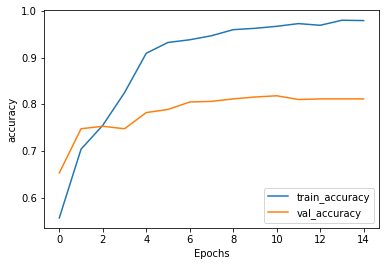

In [16]:
import matplotlib.pyplot as plt

def plot_graphs():
    plt.plot(train_acc_list)
    plt.plot(val_acc_list)
    plt.xlabel("Epochs")
    plt.ylabel("accuracy")
    plt.legend(["train_accuracy","val_accuracy"])
    plt.show()
  
plot_graphs()

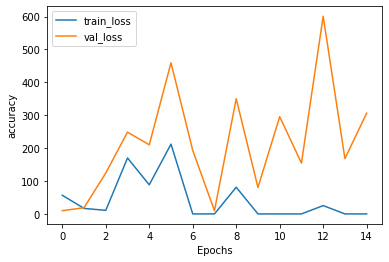

In [24]:
def plot_graphs():
    plt.plot(train_loss_list)
    plt.plot(val_loss_list)
    plt.xlabel("Epochs")
    plt.ylabel("accuracy")
    plt.legend(["train_loss","val_loss"])
    plt.show()
  
plot_graphs()